# Scratchpad

A test field for larger implementations, sectioned when appropriate.

In [1]:
import imageio
import math
import numpy as np

## Measurement tests

In [2]:
import math
def i_RMSE(stitched, original):
    total_px = len(stitched) * len(original)
    stitched = stitched.astype('float64') / (100)
    original = original.astype('float64') / (100)
    abs_err = abs(original - stitched) ** 2
    print(abs_err)
    return math.sqrt((1/total_px) * abs_err.sum())

def RMSE(s,o):
    stitched = s.astype('float64') / (100)
    original = o.astype('float64') / (100)
    abs_err = (original - stitched) ** 2
    return math.sqrt(abs_err.mean())

In [3]:
import numpy as np
x = np.array([45,67,21,89,33,56])
y = np.array([23,41,45,22,67,99])

i_RMSE(x,y)

[0.0484 0.0676 0.0576 0.4489 0.1156 0.1849]


0.16012148165967266

In [4]:
def fill_fn(fn, size):
    name = fn.__name__
    if name == 'NCC':
        return np.zeros(size)
    elif name == 'SSD' or name == 'SAD' or name == 'SRD':
        return np.full(size, np.inf)

def convolve(im, template, op):
    h_len, w_len = im.shape
    th, tw = template.shape
    op_res = fill_fn(op, (h_len-1, w_len-1))
    for i in range(h_len-th+1):
        for j in range(w_len-tw+1):
            op_res[i,j] = op(im[i:i+th, j:j+tw], template)
    return np.array(op_res)

def NCC(i1, i2):
    '''
    Normalized cross correlation, maximize this
    '''
    assert sum(i1.shape) == sum(i2.shape), 'i1 and i2 are different shapes'
    f_err = i1 - i1.mean()
    t_err = i2 - i2.mean()
    nom = (f_err * t_err).sum()
    dnom = np.square(t_err).sum() * np.square(f_err).sum()
    if math.sqrt(dnom) == 0:
        return 0
    return nom / math.sqrt(dnom)

def SSD(i1, i2):
    '''
    Sum squared differences, minimize this
    '''
    assert sum(i1.shape) == sum(i2.shape), 'i1 and i2 are different shapes'
    sum_square = np.square(i2 - i1).sum() # (A - B)^2 
    return sum_square

def SAD(i1, i2):
    '''
    sum absolute differences, minimize this
    '''
    assert sum(i1.shape) == sum(i2.shape), 'i1 and i2 are different shapes'
    sum_absolute = (abs(i2 - i1)).sum() # | A - B | 
    return sum_absolute

# mutual information
def MI(X,Y):
    '''
    Mutual information, maximize this
    '''
    bins = 256
    X = np.ravel(X)
    Y = np.ravel(Y)
    c_XY = np.histogram2d(X,Y, bins=bins)[0]
    c_X = np.histogram(X, bins=bins)[0]
    c_Y = np.histogram(Y, bins=bins)[0]

    H_X = shan_entropy(c_X)
    H_Y = shan_entropy(c_Y)
    H_XY = shan_entropy(c_XY)

    return H_X + H_Y - H_XY

def shan_entropy(c):
    c_normalized = c / float(np.sum(c))
    c_normalized = c_normalized[np.nonzero(c_normalized)]
    return -sum(c_normalized* np.log2(c_normalized)) # same as scipy.stats.entropy(c_norm, base=2)

In [5]:
import sys
sys.path.insert(0, '../src')
from util import pad

s = 256
steps = 4
x = np.random.rand(s*s).reshape(s,s)
y = x.copy()

res_rmse = []
res_ncc = []
res_sad = []
res_ssd = []
res_mi  = []
r = np.arange(-s, s+1, steps)
for i in r:
    x2 = pad(x,  i, 0) 
    y2 = pad(y, -i, 0)
#     res_rmse.append(RMSE(x2,y2))
    res_ncc.append(NCC(x2,y2))
    res_sad.append(SAD(x2,y2))
    res_ssd.append(SSD(x2,y2))
    res_mi.append( MI(x2,y2))
    

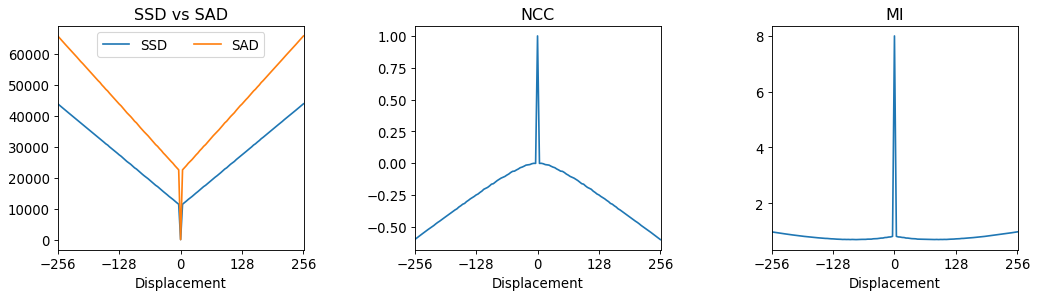

In [36]:
import matplotlib.pyplot as plt

with plt.rc_context({'font.size': 12}):
    
    fig, axes = plt.subplots(1,3, figsize=(16,4), dpi=80)

    axes[0].plot(r, res_ssd, label='SSD')
    axes[0].plot(r, res_sad, label='SAD')
    axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=False, ncol=2)
#     axes[0].set_ylabel('Difference')
    axes[0].set_title('SSD vs SAD')

    axes[1].plot(r, res_ncc)
#     axes[1].set_ylabel('Correlation')
    axes[1].set_title('NCC')

    axes[2].plot(r, res_mi)
#     axes[2].set_ylabel('Entropy')
    axes[2].set_title('MI')

    plt.subplots_adjust(top=0.8, bottom=0.1, left=0.1, right=0.85, hspace=0.25, wspace=0.45)

    for ax in axes.flatten():
        ax.set_xlabel('Displacement')
        ax.set_xticks(np.arange(-s, s+1, steps*32))
        ax.set_xlim([-s,s+1])
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(ax.title.get_text(),  bbox_inches=extent.expanded(1.4, 1.3))

    plt.show()

In [7]:
x = np.array([[1,2],[3,4]])
x2 = np.pad(x, ((2,2),(3,2)), 'constant', constant_values=(0,0))

corr = convolve(x2, x, SSD)
_y, _x = np.unravel_index(np.argmin(corr), corr.shape)  # find the match
_y, _x

(2, 3)

In [8]:
corr

array([[30., 30., 30., 30., 30., 30.],
       [30., 30., 23., 13., 22., 30.],
       [30., 30., 12.,  0., 22., 30.],
       [30., 30., 27., 33., 38., 30.],
       [30., 30., 30., 30., 30., 30.]])

In [9]:
corr = convolve(x2, x, NCC)
_y, _x = np.unravel_index(np.argmax(corr), corr.shape)  # find the match
_y, _x

(2, 3)

In [10]:
corr

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.77459667,  0.94387981,  0.25819889,
         0.        ],
       [ 0.        ,  0.        ,  0.73029674,  1.        , -0.13483997,
         0.        ],
       [ 0.        ,  0.        , -0.25819889, -0.81409158, -0.77459667,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [11]:
corr = convolve(x2, x, SRD)
_y, _x = np.unravel_index(np.argmin(corr), corr.shape)  # find the match
_y, _xd

NameError: name 'SRD' is not defined

In [ ]:
corr

## Rotation tests

In [ ]:
from PIL import Image
from scipy import ndimage
import imutils

def plot_im(im):
    plt.imshow(im)
    plt.show()

ns_ref = (128,128)
ref_src = Image.open('../data/T1_Img_002.00.tif')
ref = np.array(ref_src.copy()).astype('uint16')#.resize(ns_ref)

plot_im(ref)

In [ ]:
ref2 = imutils.rotate_bound(ref, 33)
plot_im(ref2)

In [ ]:
from util import tuple_sub

def tuple_div(t, denom=2):
    return (t[0]/denom, t[1]/denom)

tuple_div(tuple_sub(ref2.shape, ref.shape))

In [ ]:
ref3 = imutils.rotate_bound(ref2, -33)
plot_im(ref3)

In [ ]:
tuple_div(tuple_sub(ref3.shape, ref2.shape))

In [ ]:
def crop_zeros(im, zero=0, crop_vals=False):
    '''
    Crop zeros around an image
    '''
    # get the coordinates of every point > zero
    true_points = np.argwhere(im > zero)
    tl = true_points.min(axis=0) # top left corner
    br = true_points.max(axis=0) # bottom right corner
    out = im[tl[0]:br[0]+1,
             tl[1]:br[1]+1]
    if crop_vals: # top, bottom, left, right
        return out, (tl[0], br[0], tl[1], br[1])
    return out

cropped,(ty,_,tx,_) = crop_zeros(ref3.copy(), zero=500, crop_vals=True)
plot_im(cropped)
print(ty,tx)

In [ ]:
def equalize_image(stitched, target_size):
    '''
    crop or pad stitched to a target size
    '''
    sh, sw = stitched.shape
    th, tw = target_size

    nh, nw = (0,0)
    if sw < tw:
        nw = tw - sw
    elif sw > tw:
        stitched = stitched[:,:tw]

    if sh < th:
        nh = th - sh
    elif sh > th:
        stitched = stitched[:th,:]

    if nw + nh > 0:
        return np.pad(stitched, ((0, nh), (0, nw)), 'constant', constant_values=(0,0))
    return stitched

In [ ]:
x = np.array([[1,2,3], [4,5,6]])
y = np.array([[1,2], [4,5]])
assert equalize_image(x, y.shape).shape == (2,2), 'equalize_image cropped incorrectly'

y = np.array([[1,2,3], [4,5,6], [7,8,9]])
assert equalize_image(x, y.shape).shape == (3,3), 'equalize_image padded incorrectly'

y = np.array([[1,2], [4,5], [7,8]])
assert equalize_image(x, y.shape).shape == (3,2), 'equalize_image padded/cropped incorrectly'

y = np.array([[1,2,3,4], [4,5,6,7]])
assert equalize_image(x, y.shape).shape == (2,4), 'equalize_image padded/cropped incorrectly'

## Noise test

In [ ]:
import skimage # noise

mean = 0
std = 0.02
noisy = skimage.util.random_noise(ref, mode='gaussian', mean=mean, var=std)
plot_im(ref)
plot_im(noisy)

## Fiducial markers tests

In [ ]:
import math
class Point(object):
    def __init__(self,x,y):
        self.x = x
        self.y = y
        
    def __iter__(self):
        yield self.x
        yield self.y
        
    def __repr__(self):
        return '(%f,%f)' % (self.x, self.y)

class Fiducial_corners(object):
    def __init__(self, shape, initial_transform=None):
        h,w = shape
        self.center = Point(w//2, h//2)
        self.corners = []
        self.corners.append(Point(0,0)) # tl
        self.corners.append(Point(w,0)) # tr
        self.corners.append(Point(w,h)) # br
        self.corners.append(Point(0,h)) # bl    
    
        self.reassign_pts()
        if initial_transform:
            self.transform(*initial_transform, zero_out=True)
       
    def __repr__(self):
        return str(self.corners)
    
    def reassign_pts(self):
        self.tl = self.corners[0]
        self.tr = self.corners[1]
        self.br = self.corners[2]
        self.bl = self.corners[3]
    
    def min_x(self):
        return min(c.x for c in self.corners)
        
    def max_x(self):
        return max(c.x for c in self.corners)
    
    def min_y(self):
        return min(c.y for c in self.corners)
        
    def max_y(self):
        return max(c.y for c in self.corners)
    
    def transform(self, _x, _y, theta, unit='radians', temp_center=None, zero_out=False):
        if unit[0] == 'd':
            theta = theta * math.pi/180
        if temp_center:
            cx,cy = temp_center
        else:
            cx,cy = self.center
        new_corners = []
        # rotate
        if theta != 0:
            for pt in self.corners:
                nx, ny = pt
                cos_t = math.cos(theta)
                sin_t = math.sin(theta)
                # temporary points
                tx = nx - cx
                ty = ny - cy
                # rotate
                nx = tx * cos_t - ty * sin_t
                ny = ty * cos_t + tx * sin_t
                # restore old center
                nx += cx
                ny += cy
                new_corners.append(Point(nx,ny))
            self.corners = new_corners
        # translate
        new_corners = []
        if zero_out:
            _x -= self.min_x()
            _y -= self.min_y()
        for pt in self.corners:
            nx = pt.x + _x
            ny = pt.y + _y
            new_corners.append(Point(nx,ny))
        self.center.x += _x
        self.center.y += _y
        self.corners = new_corners
        self.reassign_pts()
        return self

    def transform_affine(self, M, temp_center=None):
        '''
        Transform the corners by affine matrix M
        (M already accounts for center offsets unlike the other transform func)
        '''
        if M.shape[0] < 3:
            M = np.vstack([M, [0,0,1]])
        if temp_center:
            cx,cy = temp_center
        else:
            cx,cy = self.center
        new_corners = []
        for pt in self.corners:
            x,y = pt
            # transform
            v = np.array([x,y,1])
            res = np.matmul(M, v)
            nx, ny = res[:2]
            new_corners.append(Point(nx,ny))
        self.corners = new_corners
        self.reassign_pts()
        return self
    
    
def group_transform(group, _x, _y, theta, unit='radians', temp_center=None):
    for f in group:
        f.transform(_x, _y, theta, unit=unit, temp_center=temp_center)


def group_transform_affine(group, M, temp_center=None):
    for f in group:
        f.transform_affine(M, temp_center=temp_center)


In [ ]:
def showimfids(i, fids, truthy=[]):
    fig, a = plt.subplots(1, 1, figsize=(4, 5))
    colors = ['ro', 'co', 'bo', 'yo']
    a.imshow(i, cmap='gray')
    for i,fid in enumerate(fids):
        for c in fid.corners:
            x,y = c
            a.plot(x,y, colors[i])
    for fid in truthy:
        for c in fid.corners:
            x,y = c
            a.plot(x,y, 'w*')
    plt.show()
    
ref = np.array(ref_src.copy().resize((256,256))).astype('uint16')
fids = Fiducial_corners(ref.shape)
theta = 30
x,y = (0,0)

ref = imutils.rotate_bound(ref, theta)
ref = np.pad(ref, ((y,0),(x,0)), mode='constant', constant_values=(0,0))

fids.transform(x, y, theta * math.pi/180, zero_out=True)
showimfids(ref, [fids])

ref = imutils.rotate(ref, theta)
t_ref, (ty,_,tx,_) = crop_zeros(ref, crop_vals=True)
fids.transform(-tx, -ty, -theta * math.pi/180)
showimfids(t_ref, [fids])

In [ ]:
import imageio
from imutils import resize

gt_theta = 20 * math.pi / 180
y = 0
x = 341
theta = -25

im1 = imageio.imread('../data/T1_segment_rot_1.tif')
ref_fids = Fiducial_corners(im1.shape)
im2 = imageio.imread('../data/T1_segment_rot_2.tif')
# use the base shape of the image, not the shape with rotation
mov_fids = Fiducial_corners(im1.shape, initial_transform=(0,0, gt_theta))

im2, (ty,_,tx,_) = crop_zeros(imutils.rotate(im2, -theta), crop_vals=True)
im2 = np.pad(im2, ((y,0),(x,0)), 'constant', constant_values=(0,0))
mov_fids.transform(x-tx, y-ty, theta, unit='d')

import sys
sys.path.insert(0, '../src')
from util import eq_paste

im3 = eq_paste(im1, im2)
showimfids(im3, [ref_fids, mov_fids])

In [ ]:
C = imageio.imread('../data/T1_segment_rot_3.tif')
C_fids = Fiducial_corners(im1.shape, initial_transform=(0,0,gt_theta))
D = imageio.imread('../data/T1_segment_rot_4.tif')
D_fids = Fiducial_corners(im1.shape, initial_transform=(0,0,gt_theta))

x = 320
y = 110
D = np.pad(D, ((y,0),(x,0)), 'constant', constant_values=(0,0))
D_fids.transform(x, y, 0, unit='d', zero_out=True)
CD = eq_paste(C, D)
showimfids(CD, [C_fids, D_fids])

y = 380
CD, (ty,_,tx,_) = crop_zeros(imutils.rotate(CD, -theta), crop_vals=True)
print(tx,ty)
showimfids(CD, [])
CD = np.pad(CD, ((y,0),(0,0)), 'constant', constant_values=(0,0))

# get the center point of moving image CD
min_x = min(f.min_x() for f in [C_fids, D_fids])
max_x = max(f.max_x() for f in [C_fids, D_fids])

min_y = min(f.min_y() for f in [C_fids, D_fids])
max_y = max(f.max_y() for f in [C_fids, D_fids])

temp_center = (max_x - (max_x-min_x) / 2, max_y - (max_y-min_y) / 2)

group_transform([C_fids, D_fids], -tx, y-ty, theta, unit='d', temp_center=temp_center)
showimfids(CD, [C_fids, D_fids])

In [ ]:
final = eq_paste(im3, CD)
showimfids(final, [ref_fids, mov_fids, C_fids, D_fids])

In [ ]:
def dist(p1, p2):
    L = (p1.x - p2.x)**2 + (p1.y - p2.y)**2
    return math.sqrt(L)

def edge_distances(fgroup):
    '''
    given a fiducial group calculate the distances between corresponding corners
    '''
    labels = ['A', 'B', 'C', 'D']
    g = dict(zip(labels, fgroup))
    ab1 = dist(g['A'].tr, g['B'].tl)
    ab2 = dist(g['A'].br, g['B'].bl)

    ac1 = dist(g['A'].bl, g['C'].tl)
    ac2 = dist(g['A'].br, g['C'].tr)

    cd1 = dist(g['C'].tr, g['D'].tl)
    cd2 = dist(g['C'].br, g['D'].bl)

    bd1 = dist(g['B'].bl, g['D'].tl)
    bd2 = dist(g['B'].br, g['D'].tr)
    return [ab1, ab2, ac1, ac2, cd1, cd2, bd1, bd2]

def fiducial_edge_error(gt, est):
    '''
    Compare ground truth fiducials with estimated using total registration error
    '''
    gt_dist = edge_distances(gt)
    est_dist = edge_distances(est)
    return abs(np.subtract(gt_dist, est_dist)).sum()

def fiducial_point_error(gt, est):
    labels = ['A', 'B', 'C', 'D']
    g = dict(zip(labels, gt))
    e = dict(zip(labels, est))
    err = 0
    for l in labels[1:]:
        diff = dist(g[l].tl, e[l].tl) + \
            dist(g[l].tr, e[l].tr) + \
            dist(g[l].br, e[l].br) + \
            dist(g[l].bl, e[l].bl)
        err += diff
    return err

from im_split import im_split
_, ground_truth, _ = im_split('../data/T1_Img_002.00.tif', fiducials=True, overlap=0.5, rotation=20, downsample=1024)

print(ground_truth[1].corners)
print(mov_fids, '\n')

print(fiducial_edge_error([ref_fids, mov_fids, C_fids, D_fids], ground_truth))

print(fiducial_point_error([ref_fids, mov_fids, C_fids, D_fids], ground_truth) / 12)

In [ ]:
showimfids(final, [ref_fids, mov_fids, C_fids, D_fids], truthy=ground_truth)

In [ ]:
print(mov_fids.max_x() - ref_fids.min_x(), final.shape)
print(C_fids.max_y() - ref_fids.min_x())

f_copy = mov_fids.transform(0,0,45, unit='d')
f_copy, mov_fids

### Test affine transforms

In [ ]:
th = math.pi/24
affine_fids = Fiducial_corners(im1.shape, initial_transform=[0,0,th])

a_11 = math.cos(th)
a_12 = math.sin(th)
a_21 = -a_12
a_22 = a_11
M = np.array([[a_11, a_12, 341], [a_21, a_22,0]])
affine_fids.transform_affine(M)
showimfids(im2, [affine_fids])

In [ ]:
C = imageio.imread('../data/T1_segment_rot_3.tif')
C_fids = Fiducial_corners(im1.shape, initial_transform=(0,0,gt_theta))
D = imageio.imread('../data/T1_segment_rot_4.tif')
D_fids = Fiducial_corners(im1.shape, initial_transform=(0,0,gt_theta))

x = 320
y = 110
D = np.pad(D, ((y,0),(x,0)), 'constant', constant_values=(0,0))
D_fids.transform(x, y, 0, unit='d')
CD = eq_paste(C, D)
showimfids(CD, [C_fids, D_fids])

y = 380
th = math.pi / 8
a_11 = math.cos(th)
a_12 = math.sin(th)
a_21 = -a_12
a_22 = a_11
M = np.array([[a_11, a_12, 0], [a_21, a_22, y], [0,0,1]])

CD = crop_zeros(imutils.rotate_bound(CD, -th * 180/math.pi))
CD = np.pad(CD, ((y,0),(0,0)), 'constant', constant_values=(0,0))
group_transform_affine([C_fids, D_fids], M, temp_center=Point(CD.shape[1]//2, CD.shape[0]//2))
showimfids(CD, [C_fids, D_fids])

## Padding tests

In [ ]:
def tuple_sub(t1, t2):
    '''
    Value-wise subtraction of two tuples.
    '''
    return (t1[0] - t2[0], t1[1] - t2[1])

def pad(im,x,y):
    '''
    pad an image for pasting
    '''
    x = int(x)
    y = int(y)
    if y < 0:
        vert = (0, abs(y))
    else:
        vert = (y, 0)
    if x < 0:
        horz = (0, abs(x))
    else:
        horz = (x, 0)
    return np.pad(im, (vert, horz), 'constant', constant_values=(0,0))


def ul_equalize(ref, mov):
    '''
    Make two images the same size by padding them on the bottom and right
    '''
    yd,xd = tuple_sub(mov.shape, ref.shape)
    print(yd, xd)
    if yd < 0:
        mov = pad(mov, 0, yd)
    elif yd > 0:
        ref = pad(ref, 0, -yd)
    if xd < 0:
        mov = pad(mov, xd, 0)
    elif xd > 0:
        ref = pad(ref, -xd, 0)
    return ref, mov

In [ ]:
x = np.array([[1,2,3],[3,4,5],[5,6,7],[9,10,11]])
y = np.array([[1,2], [3,4], [5,6]])

xx,yy = ul_equalize(x,y)
print(xx, '\n\n', yy)

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Load the example flights dataset and conver to long-form
flights_long = sns.load_dataset("flights")
flights = flights_long.pivot("month", "year", "passengers")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(flights, annot=True, fmt=".02f", linewidths=.5, ax=ax)